In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
from google.colab import drive
drive.mount('/drive', force_remount = True)
import IPython.display as display

Mounted at /drive


In [ ]:
#loading images
#using jpg because jpg is efficent as it requires little memory to store the images
def im_load(im):
  """Function to load and resize the image so that the length of the image is 512px"""
  im = tf.io.read_file(im)
  im = tf.image.decode_jpeg(im, channels = 3)
  im = tf.image.convert_image_dtype(im, tf.float32)
  #scaling the image
  max_size = 512 #px
  shape = tf.cast(tf.shape(im)[:-1], tf.float32)
  height = max(shape)
  scaling_factor = max_size / height
  new_shape = tf.cast(scaling_factor * shape, tf.int32)
  im = tf.image.resize(im, new_shape)
  im = im[tf.newaxis, :]
  return im

In [ ]:
#for this project, I will load images from my google drive.
style_dir = "/drive/MyDrive/NST/Style_images/"
content_dir = "/drive/MyDrive/NST/Content_images/"
style_im_list = ["s1.jpg", "s2.jpg", "s3.jpg", "s4.jpeg", "s5.jpg", "s6.jpg", "s7.jpg"] #contains names of all style images in the directory
content_im_list = ["c1.jpg", "c4.jpg", "c5.jpg", "c7.jpg"] #contains names of all content images in the directory

#Initialising 2 images
content_im = im_load(content_dir + content_im_list[0])
style_im = im_load(style_dir + style_im_list[0])

In [ ]:
#Plotting the images
def im_show(im, title = None):
  """Function to fix image shape and print them with title (if any)"""
  if len(im.shape) > 3:
    im = tf.squeeze(im, axis = 0) #(1, 512, 512, 3) --> (512, 512, 3)
  plt.imshow(im)
  if title:
    plt.title(title)

In [ ]:
vgg_model = tf.keras.applications.vgg19.VGG19(weights = "imagenet", include_top = False) #False because we only want feature extraction
                                                                                         #True would include the classifier as well, which is not needed here
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def vgg_layers(layer_name):
  vgg_model = tf.keras.applications.vgg19.VGG19(weights = "imagenet", include_top = False) 
  vgg_model.trainable = False #we dont want to train the model but use it as is
  outputs = [vgg_model.get_layer(name).output for name in layer_name]
  model = tf.keras.Model([vgg_model.input], outputs)
  return model

In [ ]:
#Calculating Gram Matrix
def gram_mat(tensor):
  res = tf.linalg.einsum("fijc,fijd->fcd", tensor, tensor) #using einstein summation
  shape = tf.shape(tensor)
  num_loc = tf.cast(shape[1] * shape[2], tf.float32)
  return res / num_loc

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocess_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_mat(output) for output in style_outputs]
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    return {"content": content_dict, "style": style_dict}

In [ ]:
#Chossing style and content layers from the model architecture provided in the summary
style_layers = ["block1_conv2", "block2_conv2", "block3_conv2", "block4_conv2", "block5_conv2"]
content_layers = ["block5_conv4"]

extractor = StyleContentModel(style_layers, content_layers)
res = extractor(tf.constant(content_im))

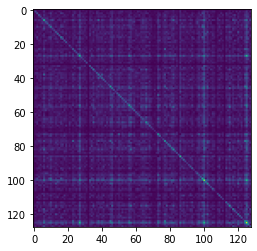

In [ ]:
#Visualising with plot
style_targets = extractor(style_im)["style"]
content_targets = extractor(content_im)["content"]
plt.imshow(style_targets["block2_conv2"].numpy()[0])

In [ ]:
#Instead of creating a new image from scratch from noise, I will use the content image and minimize that to the style image. This is because using noise would require more
#compute and time. Whereas, using content image is faster and requires less processing.
im = tf.Variable(content_im)

#normalizing image
def clip_0_1(im):
  return tf.clip_by_value(im, clip_value_min = 0.0, clip_value_max = 1.0)
#initializing Adam optimizer
optim = tf.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.99, epsilon = 1e-1)

style_weight = 5e-3
content_weight = 5e3

In [ ]:
def calc_loss(outputs):
  style_outputs = outputs["style"]
  content_outputs = outputs["content"]
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[layer] - style_targets[layer])**2) for layer in style_outputs.keys()]) * style_weight / len(style_outputs)
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[layer] - content_targets[layer])**2) for layer in content_outputs.keys()]) * content_weight / len(content_outputs)
  total_loss = style_loss + content_loss
  return total_loss

In [ ]:
#backpropagation
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(im):
  with tf.GradientTape() as tape:
    outputs = extractor(im)
    loss = calc_loss(outputs)
  grad = tape.gradient(loss, im)
  optim.apply_gradients([(grad, im)])
  im.assign(clip_0_1(im))

In [ ]:
#converting tensor to image
def tensor_to_im(tensor):
  tensor = tensor * 255 #denormalizaing the tensor
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
def run(epochs, steps):
  for epoch in range(epochs):
    display.clear_output(wait = True)
    display.display(tensor_to_im(im))
    for step in range(steps):
      step += 1
      train_step(im)

  display.clear_output(wait = True)
  display.display(tensor_to_im(im))
  return

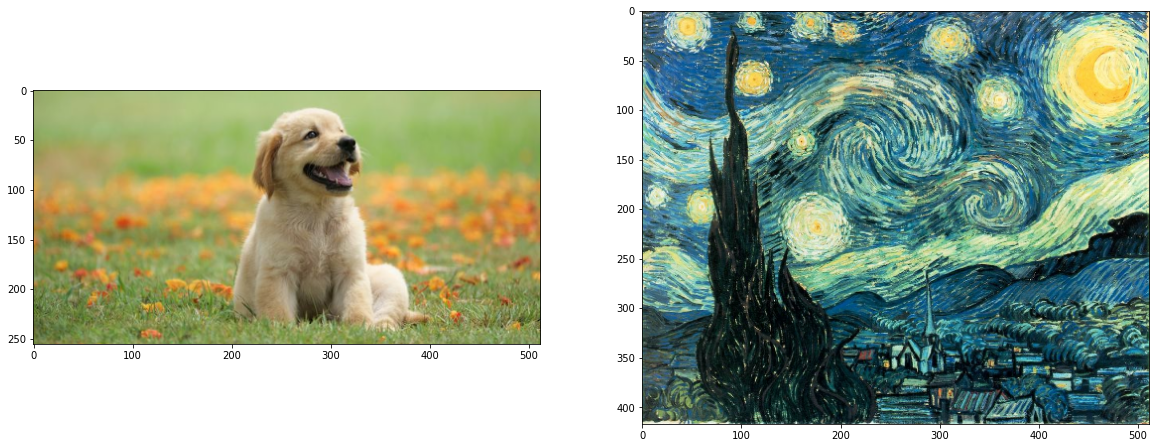

In [ ]:
#Plotting the images
plt.figure(figsize = (20, 15))
plt.subplot(1, 2, 1)
im_show(content_im)
plt.subplot(1, 2, 2)
im_show(style_im)

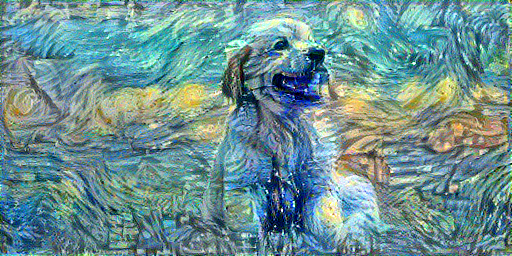

In [ ]:
run(epochs = 5, steps = 70)